<a href="https://colab.research.google.com/github/NinaAbeyratne/Cybersecurity-IDS-Optimization-GA/blob/main/GA_Feature_Mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [1]:
# Install required packages
!pip install deap scikit-learn pandas numpy matplotlib seaborn imbalanced-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 12.4 MB/s eta 0:00:00


In [2]:
# Import all libraries
import numpy as np, joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import random
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from deap import base, creator, tools

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All dependencies installed and imported successfully")

✓ All dependencies installed and imported successfully


Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the dataset

In [4]:
# Load preprocessed data
data = np.load('/content/drive/MyDrive/CI CW/preprocessed_data.npz', allow_pickle=True)
X_train_scaled = data['X_train']
X_val_scaled   = data['X_val']
X_test_scaled  = data['X_test']
y_train        = data['y_train']
y_val          = data['y_val']
y_test         = data['y_test']
feature_names  = data['feature_names'].tolist()

ga_fs_path = '/content/drive/MyDrive/CI CW/ga_feature_selection.npz'
ga_fs = np.load(ga_fs_path, allow_pickle=True)

selected_mask = ga_fs['selected_mask']
selected_features = ga_fs['selected_features'].tolist()

print("✓ GA-selected features loaded")
print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Selected features: {len(selected_features)}")

print("✓ All artifacts loaded")

✓ GA-selected features loaded
Original features: 77
Selected features: 33
✓ All artifacts loaded


In [ ]:
print(selected_mask)

[False  True False False False False False False False False False  True
 False False  True  True False  True  True False False False  True  True
 False  True  True False  True False False  True False False False False
  True  True  True False  True  True False False False  True  True False
  True False False False  True  True False False False False  True False
 False  True False  True  True  True  True False  True False  True  True
  True  True False False False]


In [ ]:
print(selected_features)

['Total Fwd Packets', 'Bwd Packet Length Mean', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Min', 'Fwd URG Flags', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Std', 'Packet Length Variance', 'PSH Flag Count', 'ACK Flag Count', 'CWE Flag Count', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Bwd Avg Bytes/Bulk', 'Subflow Fwd Packets', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'min_seg_size_forward', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean']


In [8]:
X_train_ga = X_train_scaled[:, selected_mask]
X_val_ga   = X_val_scaled[:, selected_mask]
X_test_ga  = X_test_scaled[:, selected_mask]

# Evaluation Function

In [9]:
def evaluate_model(model, X, y, model_name, n_features, n_classes):
    start_time = time.time()
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X) if hasattr(model, 'predict_proba') else None

    metrics = {
        'model_name': model_name,
        'n_features': n_features,
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y, y_pred, average='macro', zero_division=0),
        'f1_score': f1_score(y, y_pred, average='macro', zero_division=0),
        'inference_time': time.time() - start_time
    }

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    metrics['confusion_matrix'] = cm

    # Detection rate = macro recall
    metrics['detection_rate'] = metrics['recall']

    # False Positive Rate (macro)
    fpr_per_class = []
    for i in range(n_classes):
        fp = cm[:, i].sum() - cm[i, i]
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fpr_per_class.append(fp / (fp + tn + 1e-6))
    metrics['fpr'] = np.mean(fpr_per_class)

    # ROC–AUC (multiclass OvR)
    if y_proba is not None:
        y_bin = label_binarize(y, classes=list(range(n_classes)))
        metrics['roc_auc'] = roc_auc_score(y_bin, y_proba, multi_class='ovr', average='macro')
        metrics['roc_curve'] = None  # compute later if needed
    else:
        metrics['roc_auc'] = None
        metrics['roc_curve'] = None

    return metrics

In [10]:
class_names = [
    'BENIGN',
    'DDoS',
    'DoS slowloris',
    'FTP-Patator',
    'PortScan',
    'Web Attack – Brute Force'
]

n_classes = len(class_names)

print("Classes:", class_names)
print("Unique labels in y_train:", np.unique(y_train))

Classes: ['BENIGN', 'DDoS', 'DoS slowloris', 'FTP-Patator', 'PortScan', 'Web Attack – Brute Force']
Unique labels in y_train: [0 1 2 3 4 5]


# Train Optimized Model

In [11]:
print("="*60)
print("TRAINING GA-OPTIMIZED MODEL")
print("="*60)

print("Original feature count:", X_train_scaled.shape[1])
print("GA-selected feature count:", X_train_ga.shape[1])

# sanity checks
assert X_train_scaled.shape[1] == len(feature_names)
assert X_train_ga.shape[1] == len(selected_features)
assert set(np.unique(y_train)) == set(range(len(class_names)))

print("✓ Sanity checks passed")

print(f"\nTraining with {len(selected_features)} selected features...")

# Train optimized Random Forest
rf_optimized = RandomForestClassifier(
    n_estimators=300,
    max_depth=25,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)

start_time = time.time()
rf_optimized.fit(X_train_ga, y_train)
train_time_ga = time.time() - start_time

print(f"✓ Optimized model training complete")
print(f"Training time (GA-RF): {train_time_ga:.2f} seconds")

TRAINING GA-OPTIMIZED MODEL
Original feature count: 77
GA-selected feature count: 33
✓ Sanity checks passed

Training with 33 selected features...
✓ Optimized model training complete
Training time (GA-RF): 581.94 seconds


In [16]:
from sklearn.metrics import accuracy_score
# Make predictions
y_val_pred = rf_optimized.predict(X_val_ga)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.9986


In [18]:
from sklearn.metrics import f1_score

val_macro_f1 = f1_score(y_val, y_val_pred, average='macro')
print(f"Validation Macro-F1: {val_macro_f1:.4f}")


Validation Macro-F1: 0.9696


In [20]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Predict class probabilities
y_val_proba = rf_optimized.predict_proba(X_val_ga)

# Binarize true labels for multiclass ROC
y_val_bin = label_binarize(y_val, classes=range(len(class_names)))

roc_auc_macro = roc_auc_score(
    y_val_bin,
    y_val_proba,
    average="macro",
    multi_class="ovr"
)

print(f"Validation ROC-AUC (Macro, OvR): {roc_auc_macro:.4f}")


Validation ROC-AUC (Macro, OvR): 0.9997


In [22]:
import time
import numpy as np

start_time = time.time()
_ = rf_optimized.predict(X_val_ga)
end_time = time.time()

total_inference_time = end_time - start_time
inference_time_per_sample = total_inference_time / X_val_ga.shape[0]

print(f"Total Inference Time (val): {total_inference_time:.4f} seconds")
print(f"Inference Time per Sample: {inference_time_per_sample:.6f} seconds")


Total Inference Time (val): 1.4850 seconds
Inference Time per Sample: 0.000026 seconds


In [23]:
print("\n--- Validation Performance Summary ---")
print(f"Accuracy           : {val_accuracy:.4f}")
print(f"Macro-F1           : {val_macro_f1:.4f}")
print(f"ROC-AUC (Macro OvR): {roc_auc_macro:.4f}")
print(f"Inference time/sample: {inference_time_per_sample:.6f} s")



--- Validation Performance Summary ---
Accuracy           : 0.9986
Macro-F1           : 0.9696
ROC-AUC (Macro OvR): 0.9997
Inference time/sample: 0.000026 s


In [24]:
# Save model and metadata
ga_save_path = '/content/drive/MyDrive/CI CW/rf_ga_optimized.joblib'
meta_save_path = '/content/drive/MyDrive/CI CW/rf_ga_metadata.joblib'

meta = {
    'selected_features': selected_features,
    'selected_mask': selected_mask,
    'train_time_seconds': train_time_ga,
    'n_features_original': X_train_scaled.shape[1],
    'n_features_selected': X_train_ga.shape[1],
    'model_type': 'RandomForest + GA',
    'random_state': 42
}

joblib.dump(rf_optimized, ga_save_path)
joblib.dump(meta, meta_save_path)

print(f"✓ GA-Optimized RF saved to {ga_save_path}")
print(f"✓ GA metadata saved to {meta_save_path}")

✓ GA-Optimized RF saved to /content/drive/MyDrive/CI CW/rf_ga_optimized.joblib
✓ GA metadata saved to /content/drive/MyDrive/CI CW/rf_ga_metadata.joblib


In [25]:
rf_baseline_path = '/content/drive/MyDrive/CI CW/rf_baseline.joblib'
rf_baseline = joblib.load(rf_baseline_path)
print("✓ Baseline RF loaded")

✓ Baseline RF loaded


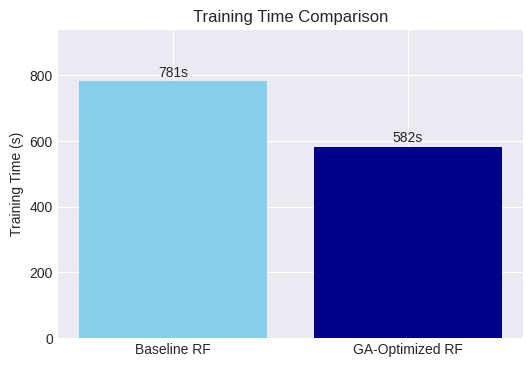

In [35]:
import matplotlib.pyplot as plt

# Model names and training times in seconds
models = ['Baseline RF', 'GA-Optimized RF']
train_times = [781, 582]  # replace with actual measured times if different

# Plot
plt.figure(figsize=(6,4))
bars = plt.bar(models, train_times, color=['skyblue', 'darkblue'])
plt.ylabel('Training Time (s)')
plt.title('Training Time Comparison')
plt.ylim(0, max(train_times)*1.2)

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval:.0f}s', ha='center', va='bottom')

plt.show()


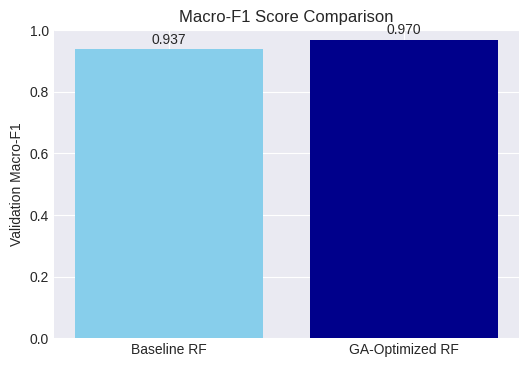

In [38]:
import matplotlib.pyplot as plt

# Models and Macro-F1 scores
models = ['Baseline RF', 'GA-Optimized RF']
macro_f1_scores = [0.9372, 0.9696]  # replace with your actual results

# Plot
plt.figure(figsize=(6,4))
bars = plt.bar(models, macro_f1_scores, color=['skyblue', 'darkblue'])
plt.ylabel('Validation Macro-F1')
plt.title('Macro-F1 Score Comparison')
plt.ylim(0, 1.0)  # F1 scores range from 0 to 1

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.show()

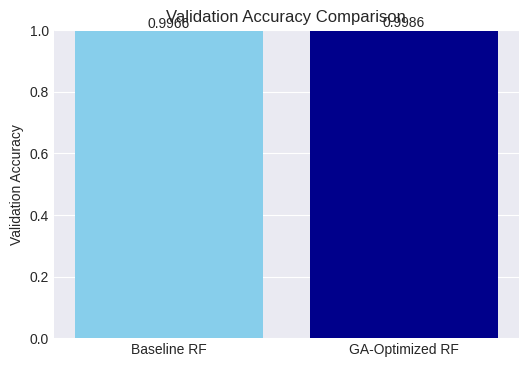

In [42]:
import matplotlib.pyplot as plt

# Models and validation accuracy
models = ['Baseline RF', 'GA-Optimized RF']
val_accuracy = [0.9966, 0.9986]  # replace with actual numbers if different

# Plot
plt.figure(figsize=(6,4))
bars = plt.bar(models, val_accuracy, color=['skyblue', 'darkblue'])
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.ylim(0, 1.0)  # accuracy ranges from 0 to 1

# Annotate bars with exact values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.4f}', ha='center', va='bottom')

plt.show()


# Final Evaluation

### Both Models

In [26]:
n_classes = len(np.unique(y_test))

baseline_metrics = evaluate_model(
    rf_baseline, X_test_scaled, y_test,
    'Baseline RF', len(feature_names), n_classes
)

ga_metrics = evaluate_model(
    rf_optimized, X_test_ga, y_test,
    'GA-Optimized RF', len(selected_features), n_classes
)

In [27]:
print("="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

# Performance improvement
f1_improvement = ((ga_metrics['f1_score'] - baseline_metrics['f1_score']) /
                  baseline_metrics['f1_score']) * 100

feature_reduction = (1 - len(selected_features)/len(feature_names)) * 100

fpr_improvement = ((baseline_metrics['fpr'] - ga_metrics['fpr']) /
                   baseline_metrics['fpr']) * 100

speed_improvement = ((baseline_metrics['inference_time'] - ga_metrics['inference_time']) /
                     baseline_metrics['inference_time']) * 100

print(f"1. MODEL PERFORMANCE:")
print(f"   Baseline F1:       {baseline_metrics['f1_score']:.4f}")
print(f"   GA-Optimized F1:   {ga_metrics['f1_score']:.4f}")
print(f"   Improvement:       {f1_improvement:+.2f}%")

print(f"\n2. FEATURE REDUCTION:")
print(f"   Original features: {len(feature_names)}")
print(f"   Selected features: {len(selected_features)}")
print(f"   Reduction:         {feature_reduction:.1f}%")

print(f"\n3. FALSE POSITIVE RATE:")
print(f"   Baseline FPR:      {baseline_metrics['fpr']:.4f}")
print(f"   GA-Optimized FPR:  {ga_metrics['fpr']:.4f}")
print(f"   Improvement:       {fpr_improvement:+.2f}%")

print(f"\n4. INFERENCE SPEED:")
print(f"   Baseline time:     {baseline_metrics['inference_time']:.4f}s")
print(f"   GA-Optimized time: {ga_metrics['inference_time']:.4f}s")
print(f"   Speed-up:          {speed_improvement:+.2f}%")
print("="*80)


FINAL SUMMARY REPORT
1. MODEL PERFORMANCE:
   Baseline F1:       0.9275
   GA-Optimized F1:   0.9601
   Improvement:       +3.52%

2. FEATURE REDUCTION:
   Original features: 77
   Selected features: 33
   Reduction:         57.1%

3. FALSE POSITIVE RATE:
   Baseline FPR:      0.0009
   GA-Optimized FPR:  0.0005
   Improvement:       +51.13%

4. INFERENCE SPEED:
   Baseline time:     1.2818s
   GA-Optimized time: 1.5016s
   Speed-up:          -17.14%


In [28]:
GA_CONFIG = {
    'alpha': 1.0, 'beta': 0.05, 'k_min': 10, 'k_max': None,
    'pop_size': 20, 'n_generations': 10, 'cx_prob': 0.7, 'mut_prob': 0.2,
    'tournament_size': 3, 'random_state': 42
}

results = {
    'baseline': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v
                 for k, v in baseline_metrics.items() if k not in ['confusion_matrix', 'roc_curve']},
    'ga_optimized': {k: float(v) if isinstance(v, (np.integer, np.floating)) else v
                     for k, v in ga_metrics.items() if k not in ['confusion_matrix', 'roc_curve']},
    'selected_features': selected_features,
    'ga_config': GA_CONFIG
}

with open('results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✓ Results saved to results.json")


✓ Results saved to results.json


All evaluation metrics were computed using macro-averaging to account for class imbalance in the multiclass intrusion detection dataset. ROC–AUC was calculated using a one-vs-rest strategy

## Feature Reduction Bar Chart

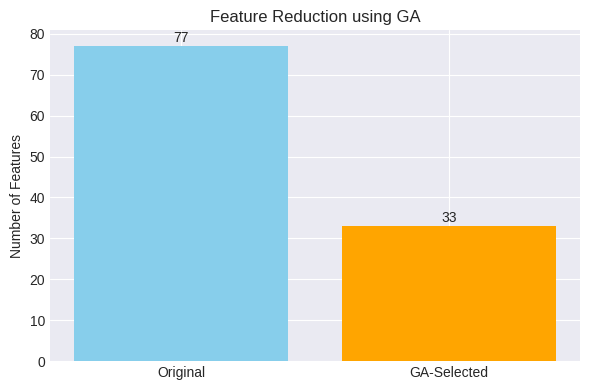

In [29]:
plt.figure(figsize=(6,4))
plt.bar(['Original', 'GA-Selected'], [X_train_scaled.shape[1], X_train_ga.shape[1]], color=['skyblue','orange'])
plt.ylabel("Number of Features")
plt.title("Feature Reduction using GA")
for i, v in enumerate([X_train_scaled.shape[1], X_train_ga.shape[1]]):
    plt.text(i, v + 1, str(v), ha='center')
plt.tight_layout()
plt.show()

## F1 Score Comparison (Baseline vs GA)

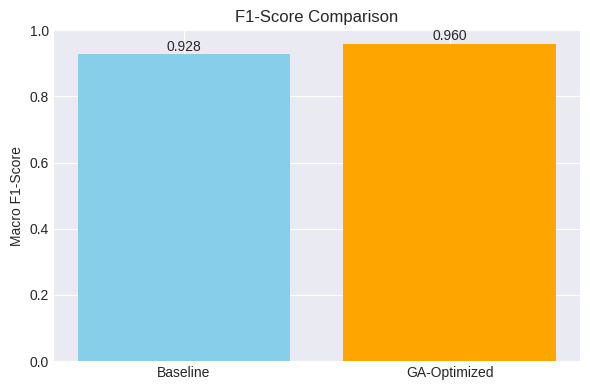

In [30]:
plt.figure(figsize=(6,4))
plt.bar(['Baseline', 'GA-Optimized'], [baseline_metrics['f1_score'], ga_metrics['f1_score']], color=['skyblue','orange'])
plt.ylabel("Macro F1-Score")
plt.title("F1-Score Comparison")
for i, v in enumerate([baseline_metrics['f1_score'], ga_metrics['f1_score']]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

## Confusion Matrices (Baseline vs GA)

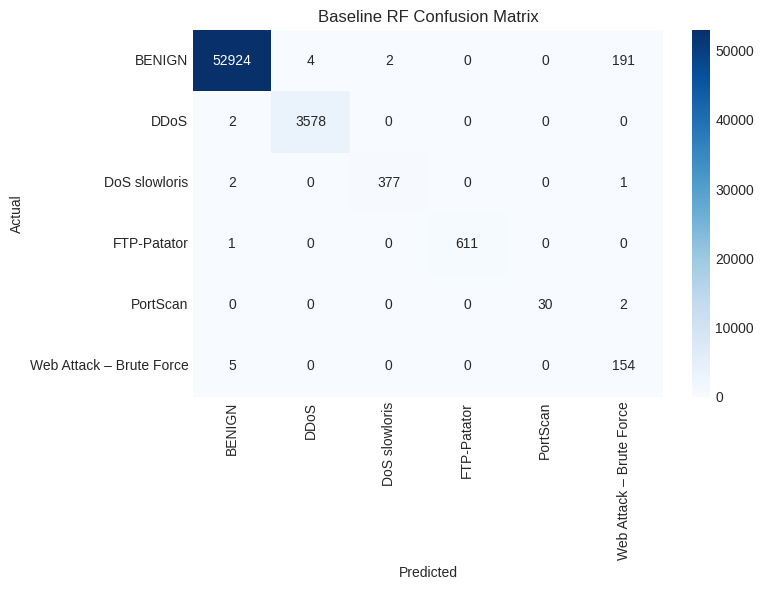

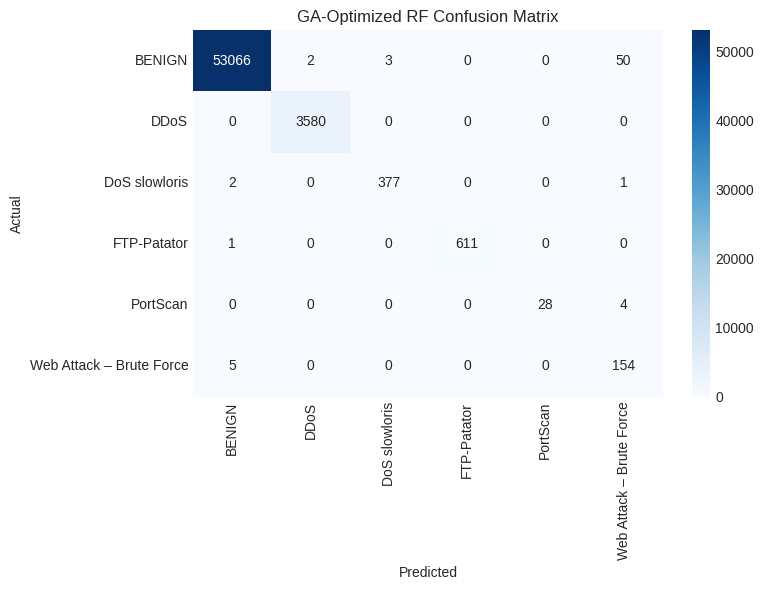

In [31]:
# Define your class names
class_names = ['BENIGN', 'DDoS', 'DoS slowloris', 'FTP-Patator', 'PortScan', 'Web Attack – Brute Force']

def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot for Baseline
plot_confusion_matrix(baseline_metrics['confusion_matrix'], class_names, "Baseline RF Confusion Matrix")

# Plot for GA-Optimized
plot_confusion_matrix(ga_metrics['confusion_matrix'], class_names, "GA-Optimized RF Confusion Matrix")

## Per-Class Metrics Bar Plot

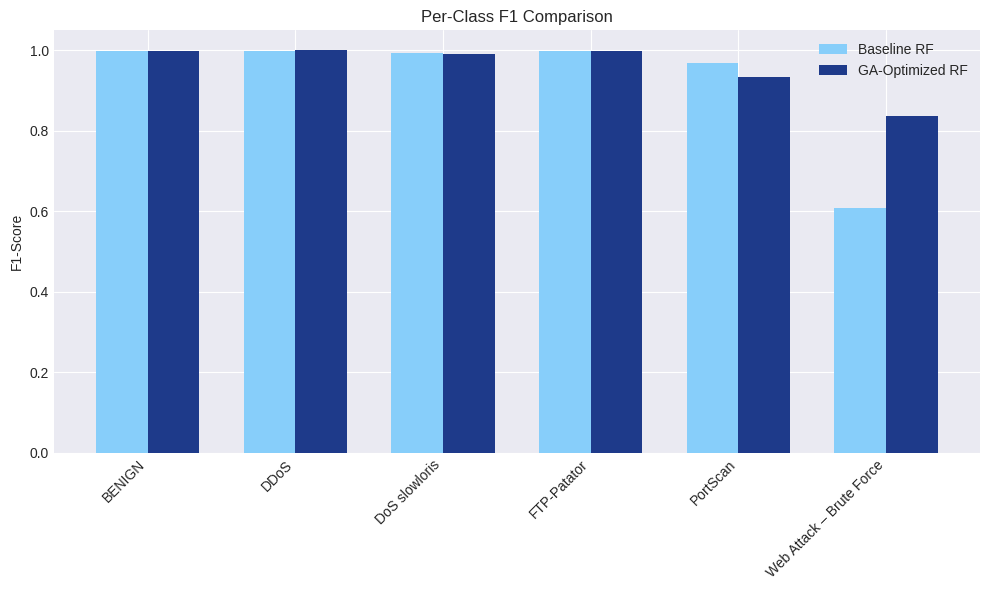

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute per-class metrics
def per_class_metrics(model, X, y, class_names):
    y_pred = model.predict(X)
    precision = precision_score(y, y_pred, average=None, zero_division=0)
    recall = recall_score(y, y_pred, average=None, zero_division=0)
    f1 = f1_score(y, y_pred, average=None, zero_division=0)
    return precision, recall, f1

# Baseline metrics
precision_base, recall_base, f1_base = per_class_metrics(rf_baseline, X_test_scaled, y_test, class_names)
# GA-Optimized metrics
precision_ga, recall_ga, f1_ga = per_class_metrics(rf_optimized, X_test_ga, y_test, class_names)

# Plot F1 comparison
x = np.arange(len(class_names))
width = 0.35

colors = {
    'lightblue': '#87CEFA',
    'darkblue': '#1E3A8A'
}

plt.figure(figsize=(10,6))
plt.bar(x - width/2, f1_base, width, label='Baseline RF', facecolor=colors['lightblue'])
plt.bar(x + width/2, f1_ga, width, label='GA-Optimized RF', facecolor=colors['darkblue'])
plt.xticks(x, class_names, rotation=45, ha='right')
plt.ylabel("F1-Score")
plt.title("Per-Class F1 Comparison")
plt.legend()
plt.tight_layout()
plt.show()


## ROC Curves (Multiclass OvR)

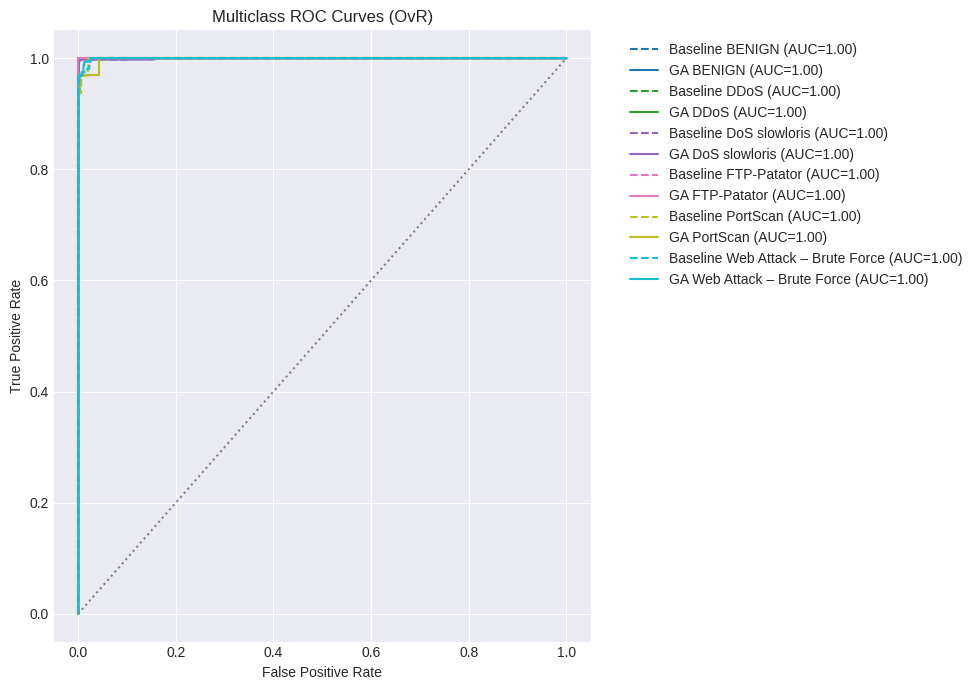

In [33]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels
y_bin = label_binarize(y_test, classes=range(len(class_names)))
n_classes = len(class_names)

# Get probabilities
y_proba_base = rf_baseline.predict_proba(X_test_scaled)
y_proba_ga   = rf_optimized.predict_proba(X_test_ga)

plt.figure(figsize=(10,7))
colors = plt.cm.get_cmap('tab10', n_classes)

for i, color in zip(range(n_classes), colors.colors):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, linestyle='--', label=f'Baseline {class_names[i]} (AUC={roc_auc:.2f})')

    fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba_ga[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, linestyle='-', label=f'GA {class_names[i]} (AUC={roc_auc:.2f})')

plt.plot([0,1], [0,1], color='gray', linestyle=':')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curves (OvR)")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


# XGBoost

In [ ]:
import xgboost as xgb

# Configure XGBoost
xgb_optimized = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=42
)

# Train
start_time = time.time()
xgb_optimized.fit(X_train_ga, y_train,
                  eval_set=[(X_val_ga, y_val)],
                  verbose=False)
train_time_xgb = time.time() - start_time
print(f"✓ GA-Optimized XGBoost trained in {train_time_xgb:.2f}s")

✓ GA-Optimized XGBoost trained in 98.32s


In [ ]:
xgb_save_path = '/content/drive/MyDrive/CI CW/xgb_ga_optimized.joblib'
meta_save_path = '/content/drive/MyDrive/CI CW/xgb_ga_metadata.joblib'

meta = {
    'selected_features': selected_features,
    'selected_mask': selected_mask,
    'train_time_seconds': train_time_xgb,
    'n_features_original': X_train_scaled.shape[1],
    'n_features_selected': X_train_ga.shape[1],
    'model_type': 'XGBoost + GA',
    'random_state': 42
}

joblib.dump(xgb_optimized, xgb_save_path)
joblib.dump(meta, meta_save_path)
print(f"✓ GA-Optimized XGBoost saved to {xgb_save_path}")

✓ GA-Optimized XGBoost saved to /content/drive/MyDrive/CI CW/xgb_ga_optimized.joblib


In [ ]:
n_classes = len(np.unique(y_test))

xgb_metrics = evaluate_model(
    xgb_optimized,
    X_test_ga,
    y_test,
    'GA-Optimized XGBoost',
    len(selected_features),
    n_classes
)

print(f"\nF1-Score: {xgb_metrics['f1_score']:.4f}, Detection Rate: {xgb_metrics['detection_rate']:.4f}")


F1-Score: 0.9830, Detection Rate: 0.9866


In [ ]:
# Evaluate all models
baseline_metrics = evaluate_model(
    rf_baseline,
    X_test_scaled,
    y_test,
    'Baseline RF',
    len(feature_names),
    n_classes
)

ga_rf_metrics = evaluate_model(
    rf_optimized,
    X_test_ga,
    y_test,
    'GA-Optimized RF',
    len(selected_features),
    n_classes
)

ga_xgb_metrics = evaluate_model(
    xgb_optimized,
    X_test_ga,
    y_test,
    'GA-Optimized XGBoost',
    len(selected_features),
    n_classes
)

models_metrics = [baseline_metrics, ga_rf_metrics, ga_xgb_metrics]
model_names = [m['model_name'] for m in models_metrics]

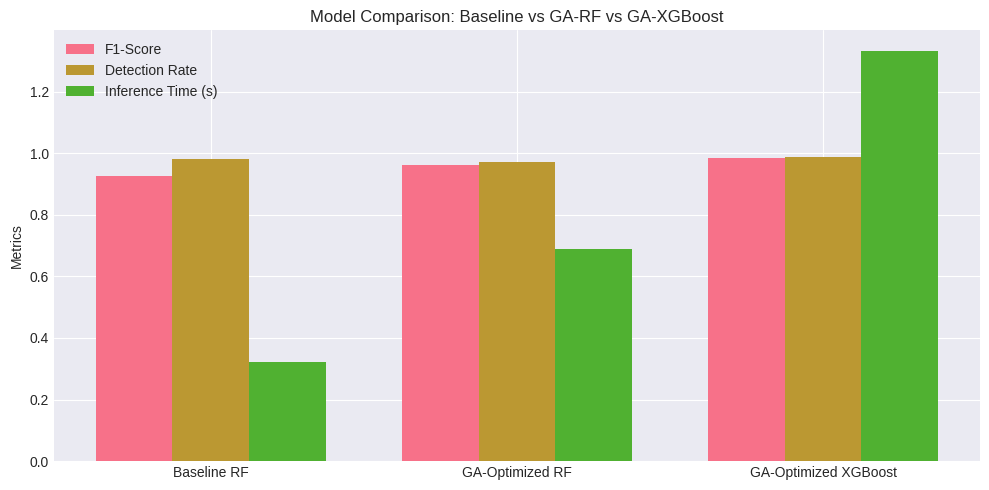

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics
f1_scores = [m['f1_score'] for m in models_metrics]
detection_rates = [m['detection_rate'] for m in models_metrics]
inference_times = [m['inference_time'] for m in models_metrics]

x = np.arange(len(model_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width, f1_scores, width, label='F1-Score')
rects2 = ax.bar(x, detection_rates, width, label='Detection Rate')
rects3 = ax.bar(x + width, inference_times, width, label='Inference Time (s)')

ax.set_ylabel('Metrics')
ax.set_title('Model Comparison: Baseline vs GA-RF vs GA-XGBoost')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
plt.tight_layout()
plt.show()

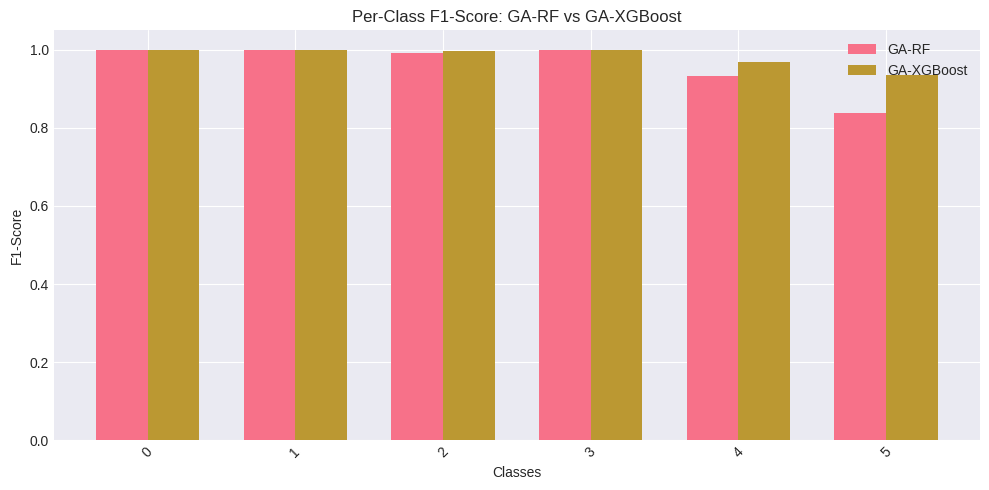

In [ ]:
# Plot per-class F1-scores for GA-RF and GA-XGBoost
classes = np.unique(y_test)
n_classes = len(classes)

from sklearn.metrics import f1_score

f1_ga_rf_per_class = f1_score(y_test, rf_optimized.predict(X_test_ga), average=None)
f1_ga_xgb_per_class = f1_score(y_test, xgb_optimized.predict(X_test_ga), average=None)

fig, ax = plt.subplots(figsize=(10,5))
width = 0.35
x = np.arange(n_classes)

rects1 = ax.bar(x - width/2, f1_ga_rf_per_class, width, label='GA-RF')
rects2 = ax.bar(x + width/2, f1_ga_xgb_per_class, width, label='GA-XGBoost')

ax.set_xlabel('Classes')
ax.set_ylabel('F1-Score')
ax.set_title('Per-Class F1-Score: GA-RF vs GA-XGBoost')
ax.set_xticks(x)
ax.set_xticklabels([str(c) for c in classes], rotation=45)
ax.legend()
plt.tight_layout()
plt.show()
